In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn

<AxesSubplot:>

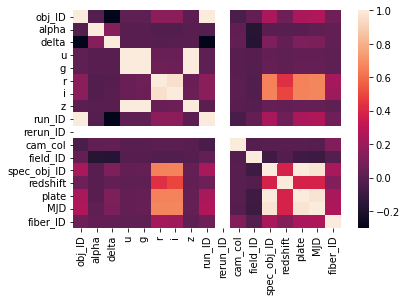

In [2]:
import seaborn as sns

df = pd.read_csv("C:/Users/kzhan/Desktop/pytorchTutorial/datasets/star_classification.csv")
tm = df.corr()
sns.heatmap(tm)

In [3]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

df = df.drop(["obj_ID", "run_ID", "rerun_ID", "cam_col", "field_ID", "spec_obj_ID", "fiber_ID", "MJD"], axis = 1)
X, y = df.drop(["class"], axis = 1), df["class"]
y = y.map({"GALAXY": 0, "QSO": 1, "STAR": 2})

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train = torch.from_numpy(np.array(X_train).astype(np.float32)).float()
X_test = torch.from_numpy(np.array(X_test).astype(np.float32)).float()

y_train = torch.from_numpy(np.array(y_train)).long()
y_test = torch.from_numpy(np.array(y_test)).long()

In [5]:
class StarClassifier(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(StarClassifier, self).__init__()

        self.linear_1 = nn.Linear(input_dim, hidden_dim)
        self.relu_1 = nn.ReLU()

        self.linear_2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu_2 = nn.ReLU()

        self.linear_3 = nn.Linear(hidden_dim, output_dim)
        self.relu_3 = nn.ReLU()
    
    def forward(self, x):
        output = self.relu_1(self.linear_1(x))
        output = self.relu_2(self.linear_2(output))
        output = self.relu_3(self.linear_3(output))
        return output

n_samples, n_features = X_train.shape
n_classes = len(np.unique(df["class"]))
model = StarClassifier(n_features, hidden_dim = 1500, output_dim = 3)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
criterion = torch.nn.CrossEntropyLoss()

In [6]:
import tqdm

batch_size = 100
n_iters = 3000
n_epochs = int(n_iters / (len(X_train) / batch_size))

loss_list = torch.zeros((n_epochs, ))
accuracy_list = torch.zeros((n_epochs))

for epoch in tqdm.trange(n_epochs):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss_list[epoch] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        y_pred_2 = model(X_test)
        correct = (torch.argmax(y_pred_2, dim = 1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 3/3 [00:14<00:00,  4.97s/it]
